In [1]:
"""
The script demonstrates a simple example of using ART with Keras. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# replace tqdm imported by any other module with tqdm.notebook
import sys
import tqdm
from tqdm.notebook import tqdm
sys.modules["tqdm"].tqdm = tqdm
sys.modules["tqdm.tqdm"] = tqdm
import ipywidgets as widgets # check if this is installed to make normal tqdm work inside the notebook

import os
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import numpy as np
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input, VGG16

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.externals import joblib
import time
import platform
import subprocess
import shutil
import load10_temp as ltemp

try:
    import tensorflow as tf
    # tf.config.run_functions_eagerly(False)
    tf.compat.v1.disable_eager_execution()
except:
    print("Failed to disable tensorflow eager execution")

# Configure a logger to capture ART outputs; these are printed in console and the level of detail is set to INFO
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s [%(levelname)s] %(message)s", datefmt='%Y-%m-%d %H:%M:%S')
handler.setFormatter(formatter)
logger.addHandler(handler)


Using TensorFlow backend.


In [2]:
img_size = 224
extra_model = 'big'
if (platform.system() == "Windows"):
    model = load_model(os.path.join(os.getcwd(), 'model.h5'))
else:
    # model = load_model(os.path.join(os.getcwd(), 'model.h5'))
    model = load_model(os.path.join(os.getcwd(), 'model_{}_{}.h5'.format(img_size, extra_model)))
print(model.summary())



2021-03-30 00:35:44 [WARNING] From /home/ec1018/anaconda3/envs/atf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


2021-03-30 00:35:44 [WARNING] From /home/ec1018/anaconda3/envs/atf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.


2021-03-30 00:35:44 [WARNING] From /home/ec1018/anaconda3/envs/atf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.


2021-03-30 00:35:45 [WARNING] From /home/ec1018/anaconda3/envs/atf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.


2021-03-30 00:35:45 [WARNING] From /home/ec1018/anaconda3/envs/atf/lib/python3.7/site-packages/keras/back

In [3]:
render_util_folder = os.getcwd()
if (platform.system() == "Windows"):
    blender_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\blender-2.78c-windows64" 
    dataset_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\greebles-generator-master\Greebles_3DS_10"
else:
    blender_folder = r"/home/ec1018/projects/blender-2.78c-linux-glibc219-x86_64"
    dataset_folder = r"/home/ec1018/projects/Greebles_3DS_10"

render_folder = os.path.join(os.getcwd(), "greebles_10") #reduced dataset of 10
    
if not os.path.isdir(dataset_folder):
    raise OSError(2, 'No such directory', str(dataset_folder))
if not os.path.exists(os.path.join(render_util_folder, 'render.py')):
    raise OSError(2, 'render.py not found', str(render_util_folder))

render_script = os.path.join(render_util_folder, 'render.py')

# Find the correct version of blender depending on the OS
if (platform.system() == "Windows"):
    blender_exec = os.path.join(blender_folder, 'blender.exe')
else:
    blender_exec = os.path.join(blender_folder, 'blender')
    
if not os.path.exists(os.path.join(blender_folder, blender_exec)):
    raise OSError(2, 'Blender executable not found', str(blender_folder))

set_mode = 'specific_all'
set_type = 'specific_angle'
source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)

labels = {0: 'f-1', 1: 'f-2', 2: 'f-3', 3: 'f-4', 4: 'f-5', 5: 'm-1', 6: 'm-2', 7: 'm-3', 8: 'm-4', 9: 'm-5'}

In [4]:
# Step 3: Create the ART classifier
min_pixel_value = 0.0
max_pixel_value = 1.0
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

2021-03-30 00:35:56 [INFO] Inferred 21 hidden layers on Keras classifier.


In [5]:
test_set_name = "greebles10_test_-90_90_1_{}.npy".format(img_size)
test_set_path = os.path.join(source_folder, test_set_name)
all_test = joblib.load(test_set_path)

all_acc = {}
for k in all_test.keys():
    (x_test, y_test) = np.copy(all_test[k][0]), np.copy(all_test[k][1])
    # Normalize
    x_test *= (1.0/255)
    # Calculate accuracy
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    all_acc[k] = accuracy
    print("Accuracy on {} degrees: {}%".format(k, accuracy * 100))

Accuracy on -90 degrees: 40.0%
Accuracy on -89 degrees: 40.0%
Accuracy on -88 degrees: 40.0%
Accuracy on -87 degrees: 40.0%
Accuracy on -86 degrees: 40.0%
Accuracy on -85 degrees: 40.0%
Accuracy on -84 degrees: 40.0%
Accuracy on -83 degrees: 40.0%
Accuracy on -82 degrees: 40.0%
Accuracy on -81 degrees: 40.0%
Accuracy on -80 degrees: 40.0%
Accuracy on -79 degrees: 40.0%
Accuracy on -78 degrees: 40.0%
Accuracy on -77 degrees: 40.0%
Accuracy on -76 degrees: 40.0%
Accuracy on -75 degrees: 40.0%
Accuracy on -74 degrees: 40.0%
Accuracy on -73 degrees: 40.0%
Accuracy on -72 degrees: 40.0%
Accuracy on -71 degrees: 40.0%
Accuracy on -70 degrees: 40.0%
Accuracy on -69 degrees: 40.0%
Accuracy on -68 degrees: 40.0%
Accuracy on -67 degrees: 40.0%
Accuracy on -66 degrees: 40.0%
Accuracy on -65 degrees: 40.0%
Accuracy on -64 degrees: 40.0%
Accuracy on -63 degrees: 40.0%
Accuracy on -62 degrees: 40.0%
Accuracy on -61 degrees: 40.0%
Accuracy on -60 degrees: 50.0%
Accuracy on -59 degrees: 50.0%
Accuracy

In [6]:
# Put all the different angles in a dictionary to access individually later
all_test = {}

eps_param = 0.05

extra_set = "fgsm" + str(eps_param).replace(".",""); y_rot = 0
# extra_set = "upsidedown_fgsm"; y_rot = 180

test_set_gen_params = [-90, 90, 1]
# test_set_gen_params = [85, 90, 1]

test_set_name = "greebles10_{}_{}_{}_{}_{}.npy".format(extra_set,
                test_set_gen_params[0], test_set_gen_params[1], test_set_gen_params[2], img_size)

test_set_path = os.path.join(source_folder, test_set_name)

if not (os.path.isfile(test_set_path)):
    # Generate test set
    for z in range(test_set_gen_params[0], test_set_gen_params[1] + 1, test_set_gen_params[2]):

        blender_process = subprocess.run([blender_exec, '-b', '-P', render_script, '--', 
                            '-st', set_type, '-sm', set_mode, '-rp', render_folder, '-dp', dataset_folder, '-rm', 'none', '-pf', 'tensorflow',
                            '-is', str(img_size), '-ni', '1', '-xr', '0', '-yr', str(y_rot), '-zr', str(z)])

        # Move training set to folder                    
        source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
        ltemp.move_to_folder(source_folder, os.path.join(source_folder, "test"))

        print(z, end=", ")
        (x_test, y_test) = ltemp.load_dataset_temp("test", source_folder)
        x_test = np.array(x_test, dtype='float64')
        y_test = np.array(y_test, dtype='float32')
        x_test *= (1.0/255)
        print(np.max(x_test))

        attack = FastGradientMethod(classifier, eps=eps_param, batch_size=10)
        # print("Craft attack test examples")
        x_test_adv = attack.generate(x_test, y_test)

        all_test[str(z)] = (x_test_adv, y_test)
    
    # Save the concatenated set after loop
    joblib.dump(all_test, test_set_path)

print("Done:", test_set_path)
# print("\n", all_test["90"][0].shape)


Done: /home/ec1018/projects/pycharm/adversarial-robustness-toolbox/my_scripts/greebles_10/greebles_tf-specific_all/specific_angle/greebles10_fgsm005_-90_90_1_224.npy


In [7]:
# Loading to test if it worked
print("Loading:", test_set_path)
all_test = joblib.load(test_set_path)
##### Test specific #####
# test_set_path_specific = os.path.join(os.path.dirname(test_set_path), 'greebles10_fgsm03_-90_90_1_224.npy')
# print("Loading:", test_set_path_specific)
# all_test = joblib.load(test_set_path_specific)
#########################

print("\n", all_test["90"][0].shape)

Loading: /home/ec1018/projects/pycharm/adversarial-robustness-toolbox/my_scripts/greebles_10/greebles_tf-specific_all/specific_angle/greebles10_fgsm005_-90_90_1_224.npy

 (10, 224, 224, 1)


(10, 224, 224, 1)


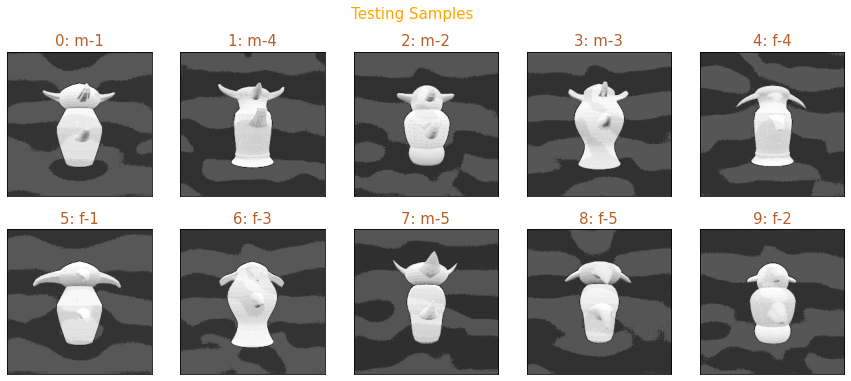

In [8]:
# Display one specific angle just as an example of what images are we using
angle_used = '10'
(x_test, y_test) = np.copy(all_test[angle_used][0]), np.copy(all_test[angle_used][1])
# Make background the same color
# x_test[x_test < 70] = 0
# x_test *= (1.0/255)
print(x_test.shape)

fig, axes = plt.subplots(2, 5, figsize=(15,6))
for i,ax in enumerate(axes.flat):
    ax.imshow(x_test[i][:,:,0], cmap='Greys_r')
    true_label = np.argwhere(y_test[i] == 1).flatten()
    ax.set_title("{number}: {label}".format(label=labels[int(true_label)], number=i), fontsize=15, color='#ba5e27')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.tick_params(axis=u'both', which=u'both', length=0)

fig.suptitle('Testing Samples', fontsize=15, color='orange')

plt.show()

In [9]:
all_acc = {}
for k in all_test.keys():
    (x_test, y_test) = np.copy(all_test[k][0]), np.copy(all_test[k][1])
    # Normalize
    # x_test *= (1.0/255)
    # Calculate accuracy
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    all_acc[k] = accuracy
    print("Accuracy on adv {} degrees: {}%".format(k, accuracy * 100))

Accuracy on adv -90 degrees: 0.0%
Accuracy on adv -89 degrees: 0.0%
Accuracy on adv -88 degrees: 0.0%
Accuracy on adv -87 degrees: 0.0%
Accuracy on adv -86 degrees: 0.0%
Accuracy on adv -85 degrees: 0.0%
Accuracy on adv -84 degrees: 0.0%
Accuracy on adv -83 degrees: 0.0%
Accuracy on adv -82 degrees: 0.0%
Accuracy on adv -81 degrees: 0.0%
Accuracy on adv -80 degrees: 0.0%
Accuracy on adv -79 degrees: 0.0%
Accuracy on adv -78 degrees: 0.0%
Accuracy on adv -77 degrees: 0.0%
Accuracy on adv -76 degrees: 0.0%
Accuracy on adv -75 degrees: 0.0%
Accuracy on adv -74 degrees: 0.0%
Accuracy on adv -73 degrees: 0.0%
Accuracy on adv -72 degrees: 0.0%
Accuracy on adv -71 degrees: 0.0%
Accuracy on adv -70 degrees: 0.0%
Accuracy on adv -69 degrees: 0.0%
Accuracy on adv -68 degrees: 0.0%
Accuracy on adv -67 degrees: 0.0%
Accuracy on adv -66 degrees: 0.0%
Accuracy on adv -65 degrees: 0.0%
Accuracy on adv -64 degrees: 0.0%
Accuracy on adv -63 degrees: 0.0%
Accuracy on adv -62 degrees: 0.0%
Accuracy on ad

In [10]:
# Clear allocated memory for the GPU
try:
    from numba import cuda
    cuda.select_device(0)
    cuda.close()
    print("Cleared memory")
except:
    print("Could not clear memory")

2021-03-30 00:36:08 [INFO] init
2021-03-30 00:36:08 [INFO] reset context of device 0
Cleared memory
